#### 데이터 불러오기
* kaggle datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

## raw_data
data = '/content/drive/MyDrive/Datasets/vgames2.csv'
##kaggle_data
kdata = '/content/drive/MyDrive/Datasets/vgsales.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



|feature|description|
|:---:|-----|
|Rank | Ranking of overall sales |
| Name | The games name|
| Platform | Platform of the games release (i.e. PC,PS4, etc.) |
| Year | Year of the game's release|
| Genre | Genre of the game|
| Publisher | Publisher of the game|
| NA_Sales | Sales in North America (in millions)|
| EU_Sales | Sales in Europe (in millions)|
| JP_Sales | Sales in Japan (in millions)|
| Other_Sales | Sales in the rest of the world (in millions)|
| Global_Sales | Total worldwide sales |
reference https://www.kaggle.com/gregorut/videogamesales

#### 라이브러리

In [2]:
### 한글깨짐방지
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [3]:
!pip install plotly
import plotly.express as px

In [4]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
sys_font = fm.findSystemFonts()
#[f for f in sys_font if 'Nanum' in f]

In [5]:
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=path, size = 10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()

NanumBarunGothic


In [6]:
## library
import time 
import pandas as pd
import numpy as np

import matplotlib as mpl
%matplotlib inline
import seaborn as sns
import missingno as msno
import re

import warnings
warnings.filterwarnings('ignore')

# figure size 크게 변환
from matplotlib import rcParams

In [7]:
df = pd.read_csv(data)    # aib data
dfk = pd.read_csv(kdata)  # kaggle data 

## 데이터 EDA

In [8]:
print(f"shape: {dfk.shape}")
dfk.head(3)

shape: (16598, 11)


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82


In [9]:
#dfk.info()
#dfk.columns #['Rank', 'Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
dfk.describe().T

,count,mean,std,min,25%,50%,75%,max
Rank,16598.0,8300.605254,4791.853933,1.00,4151.25,8300.50,12449.75,16600.00
Year,16327.0,2006.406443,5.828981,1980.00,2003.00,2007.00,2010.00,2020.00
NA_Sales,16598.0,0.264667,0.816683,0.00,0.00,0.08,0.24,41.49
EU_Sales,16598.0,0.146652,0.505351,0.00,0.00,0.02,0.11,29.02
JP_Sales,16598.0,0.077782,0.309291,0.00,0.00,0.00,0.04,10.22
Other_Sales,16598.0,0.048063,0.188588,0.00,0.00,0.01,0.04,10.57
Global_Sales,16598.0,0.537441,1.555028,0.01,0.06,0.17,0.47,82.74


- 평균비교하면 NA > EU> JP> Other, 특히 NA 는 상위 50, 최대값이 유별나게 큰 편
- year: 1980 - 2020, 결측치 존재

In [10]:
dfk.describe(include = 'object')

,Name,Platform,Genre,Publisher
count,16598,16598,16598,16540
unique,11493,31,12,578
top,Need for Speed: Most Wanted,DS,Action,Electronic Arts
freq,12,2163,3316,1351


- Platform :  unique = 31
- genre: unique = 12 
- publisher : 결측치 존재

In [11]:
# 결측치 
def missing_value(dfk):
    missing_cols = [(col, dfk[col].isnull().sum()) for col in dfk.columns if dfk[col].isnull().sum() != 0]
    #msno.matrix(dfk, figsize = (17,12))
    #print(missing_cols)
    missing_val = pd.DataFrame(missing_cols, columns = ['column','num of missing values'])
    return missing_val

missing_value(dfk)

,column,num of missing values
0,Year,271
1,Publisher,58


In [12]:
# 중복치 확인
dfk.duplicated().sum()

# 타입 확인
dfk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


### 결측치 보완
1. Year 
    - 결측치 데이터들을 살펴보면 platform, genre 등을 통해 연도 유추 가능
    - 뿐만아니라 게임 데이터는 시간에 따라 사용하는 플랫폼도 변화하는 추세이므로 
    - 플랫폼을 기준으로 (사용) 연도의 평균을 계산하여 결측값을 보완함

2. Publisher
    - 'unknown' 이라는 별도의 category를 설정해 분류 

#### Year

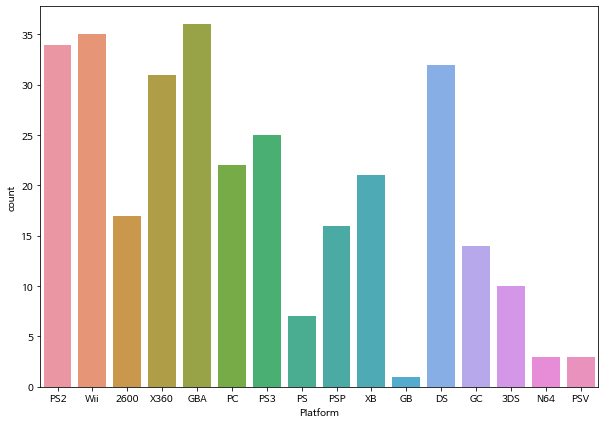

In [13]:
## 결측치 포함 데이터
dfk_null = dfk[dfk.isnull().any(axis = 1) == True]
# 결측치 데이터들의 platform 분포
plt.figure(figsize = (10,7))
sns.countplot(dfk_null.Platform)

In [14]:
# 플랫폼- 연도별 변화량(추이)를 대충 가늠할 수 있음
pd.set_option('display.max_columns',50)
dfk.pivot_table(columns = ['Year'], index = ['Platform'], values =['Global_Sales']).stack().unstack().style.highlight_null(null_color = 'gray')

In [15]:
# 결측치가 있는 값들의 platform 
plaforms = dfk_null.Platform.values
# 해당 platform의 평균 연도 
plaform_year_mean = pd.DataFrame(dfk.groupby(['Platform'])['Year'].mean().round(0))

# 결측치 매핑
dfk.loc[dfk['Year'].isnull(), 'Year'] = dfk['Platform'].map(plaform_year_mean.Year)
# 결측값 확인
dfk.Year.isnull().sum()

0

#### Publisher

In [16]:
dfk.loc[dfk['Publisher'].isnull(), 'Publisher'] = dfk['Publisher'].fillna('unknown')
dfk.Publisher.isnull().sum()

0

## 데이터 분석 

In [17]:
dfk.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [18]:
#dfk.Year.value_counts()

In [19]:
dfk_year_region = dfk.groupby(['Year'])['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales'].sum()
dfk_year_platform = dfk.pivot_table(index = ['Year'], columns = ['Platform'], values = ['Global_Sales'])
dfk_year_genre = dfk.pivot_table(index = ['Year'], columns = ['Genre'], values = ['Global_Sales'])

### 연도별 게임 판매량 추이
- 지역별/장르별/플랫폼별

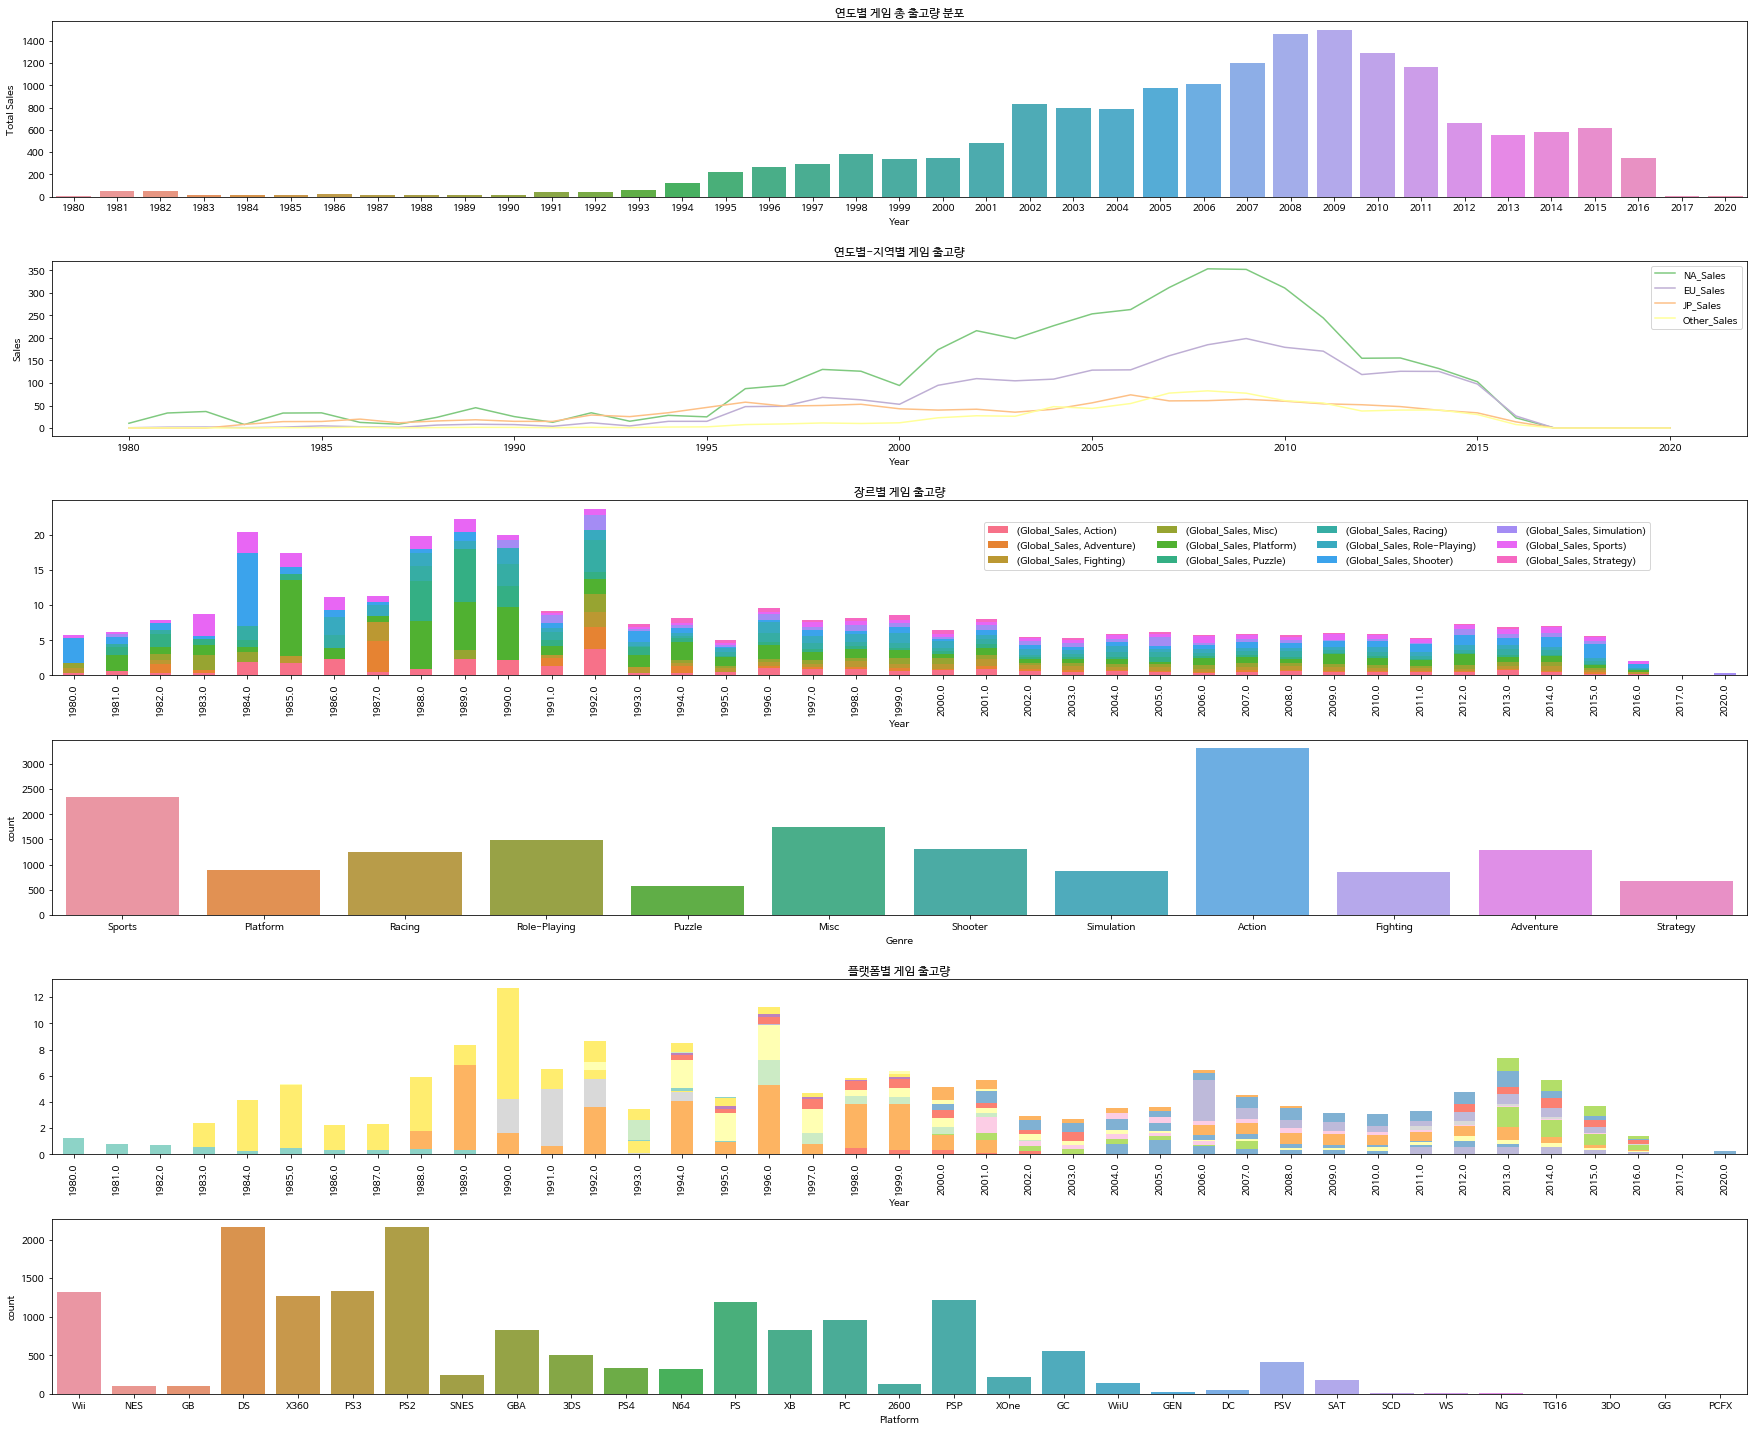

In [20]:
sns.set_palette('Accent')
# Year -- .to_datetime
dfk['Year'] = pd.to_datetime(dfk.Year, format = '%Y').dt.year

# 연도별/ 수치데이터 시각화
fig, axes = plt.subplots(6,1, figsize = (25,20))
ax = axes.flatten()

ax[0].set_title("연도별 게임 총 출고량 분포")
sns.countplot(x = 'Year', data = dfk, ax = ax[0])
ax[0].set_ylabel('Total Sales')

ax[1].set_title("연도별-지역별 게임 출고량")
sns.lineplot(data = dfk_year_region, x = 'Year', y = 'NA_Sales', ax=ax[1], label = 'NA_Sales')
sns.lineplot(data = dfk_year_region, x = 'Year', y = 'EU_Sales', ax=ax[1], label = 'EU_Sales')
sns.lineplot(data = dfk_year_region, x = 'Year', y = 'JP_Sales', ax=ax[1], label ='JP_Sales')
sns.lineplot(data = dfk_year_region, x = 'Year', y = 'Other_Sales', ax=ax[1], label = 'Other_Sales')
ax[1].legend()
ax[1].set_ylabel('Sales')

ax[2].set_title("장르별 게임 출고량")
qualitative_colors = sns.color_palette("husl", 12)
dfk_year_genre.plot.bar(stacked = True, ax = ax[2], color = qualitative_colors)
sns.countplot(x = 'Genre', data = dfk, ax = ax[3])
ax[2].legend(loc=(0.55,0.6), ncol= 4)

ax[4].set_title("플랫폼별 게임 출고량")
qualitative_colors = sns.color_palette("Set3", 32)
dfk_year_platform.plot.bar(stacked = True, ax = ax[4], color = qualitative_colors)
sns.countplot(x = 'Platform', data = dfk, ax = ax[5])
ax[4].get_legend().remove()

plt.tight_layout()
plt.show();

### 시대별 트렌드 분석

In [21]:
###### 조건에 따라 칼럼 값 설정 : np.select(cond, val) !!
dy = dfk.copy()
dy['period'] = ''

conditions = [(dy['Year'] <1990),
            (dy['Year'] >= 1900) & (dy['Year'] <2000), 
            (dy['Year'] >= 2000) & (dy['Year'] < 2010),
            (dy['Year'] >= 2010)
            ]
values = [1980,1990,2000,2010]

dy['period'] = np.select(conditions, values)
dy.period.value_counts()

2000    9386
2010    5210
1990    1780
1980     222
Name: period, dtype: int64

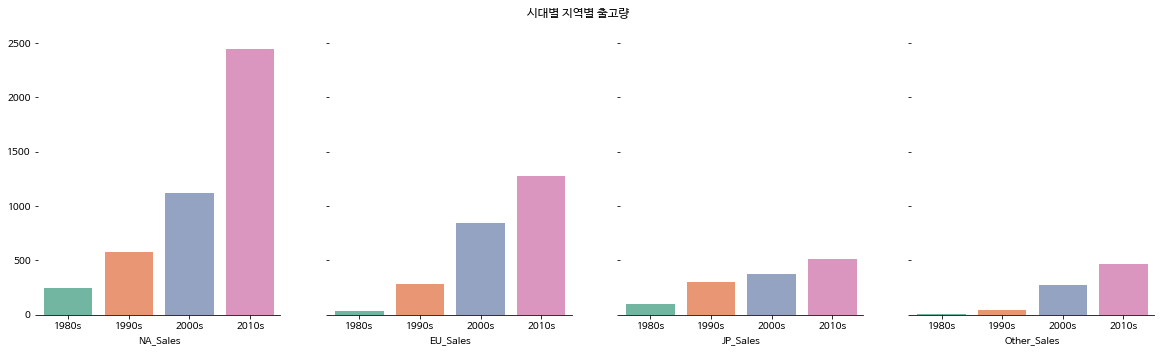

In [22]:
## 시대별 지역별 출고량
a = dy.pivot_table(index = ['period'],  values = ['NA_Sales', 'EU_Sales', 'JP_Sales','Other_Sales'], aggfunc = 'sum', fill_value = 0)

sns.set_palette('Set2')
fig, ax = plt.subplots(1,4, figsize = (20,5), sharey = True)
region_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales','Other_Sales']
periods = [1980, 1990, 2000, 2010]

for i, col in enumerate(region_cols):
    g = sns.barplot(data = a.loc[:,col], x = a.loc[:,col].index, y= a.loc[:,col].values, ax = ax[i])
    g.set_xticklabels(['1980s', '1990s', '2000s', '2010s'])
    g.set_ylim(0,2500)
    g.spines['right'].set_visible(False)  # 오른쪽, 위쪽 axis 제거
    g.spines['top'].set_visible(False)
    g.spines['left'].set_visible(False)

fig.suptitle('시대별 지역별 출고량')

plt.show();

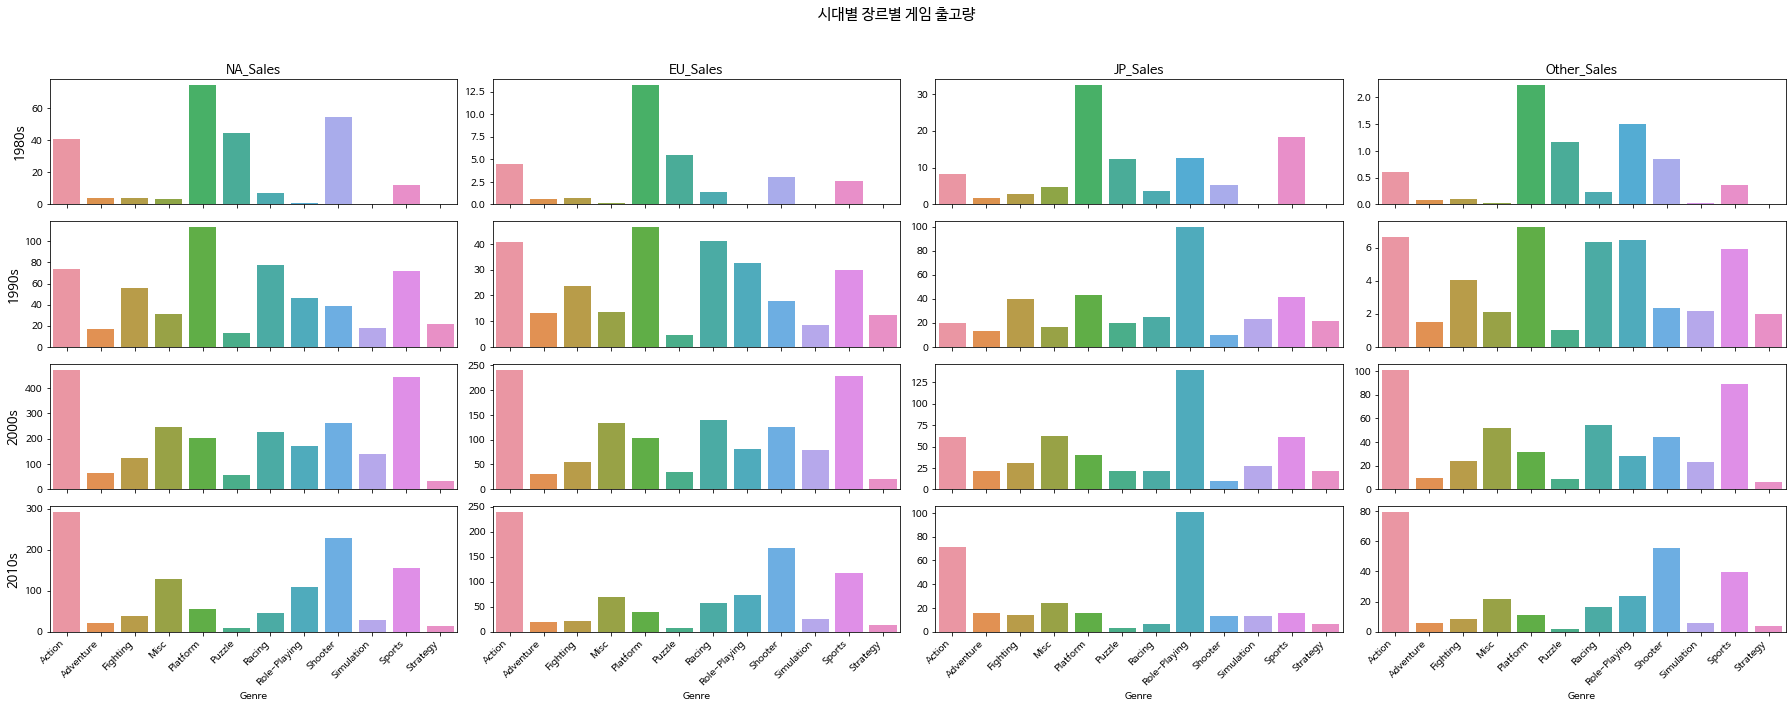

In [23]:
# 시대별 지역별 장르별 출고량 

fig, ax = plt.subplots(4,4, figsize=(25,10), sharex = True)
fig.suptitle('시대별 장르별 게임 출고량', fontsize = 15)  # overall titlte

for i, p in enumerate(periods):
    dy_period_gen = dy[dy.period == p].groupby(['Genre']).sum()
    for j, v in enumerate(region_cols):   
        sns.barplot(data =dy_period_gen, x = dy_period_gen.index, y = v,  ax = ax[i][j])   
        ax[i][j].set_ylabel('')  

ax[0][0].set_title('NA_Sales', fontsize = 13)
ax[0][1].set_title('EU_Sales',fontsize = 13)
ax[0][2].set_title('JP_Sales',fontsize = 13)
ax[0][3].set_title('Other_Sales',fontsize = 13)

ax[0][0].set_ylabel('1980s', fontsize = 13)
ax[1][0].set_ylabel('1990s',fontsize = 13)
ax[2][0].set_ylabel('2000s',fontsize = 13)
ax[3][0].set_ylabel('2010s',fontsize = 13)

fig.autofmt_xdate(rotation=45)   ########## !!!! xticks 회전 : fig.autofmt_xdate(rotation=#)

fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.show()

####  결과해석
- 북미 
    - 액션- 계속 상위권 랭크, 1990/2000년대 다양한 장르 골고루 인기, 2000년내 출고량 volume 크게 증가 
    - 80년대(플랫폼/시뮬레이션/퍼즐) --> 90년대(레이싱/스포츠/파이팅) --> 2000년대(스포츠/슈터/레이싱/롤플레링/플랫폼) -->  2010년대(슈터/스포츠/롤플레잉)
- EU
    - 북미와 비슷한 패턴
- 일본
    - 1990년대 이후 출고량 volumne 은 비슷한 수준
    - 80년대(플랫폼/스포츠/롤프레잉/퍼즐) --> 90년 부터 롤플레잉 압도적 1위 유지
- 기타
    - 80년대(플랫폼/퍼즐/롤플레잉/슈터) --> 액션/스포츠/슈터 

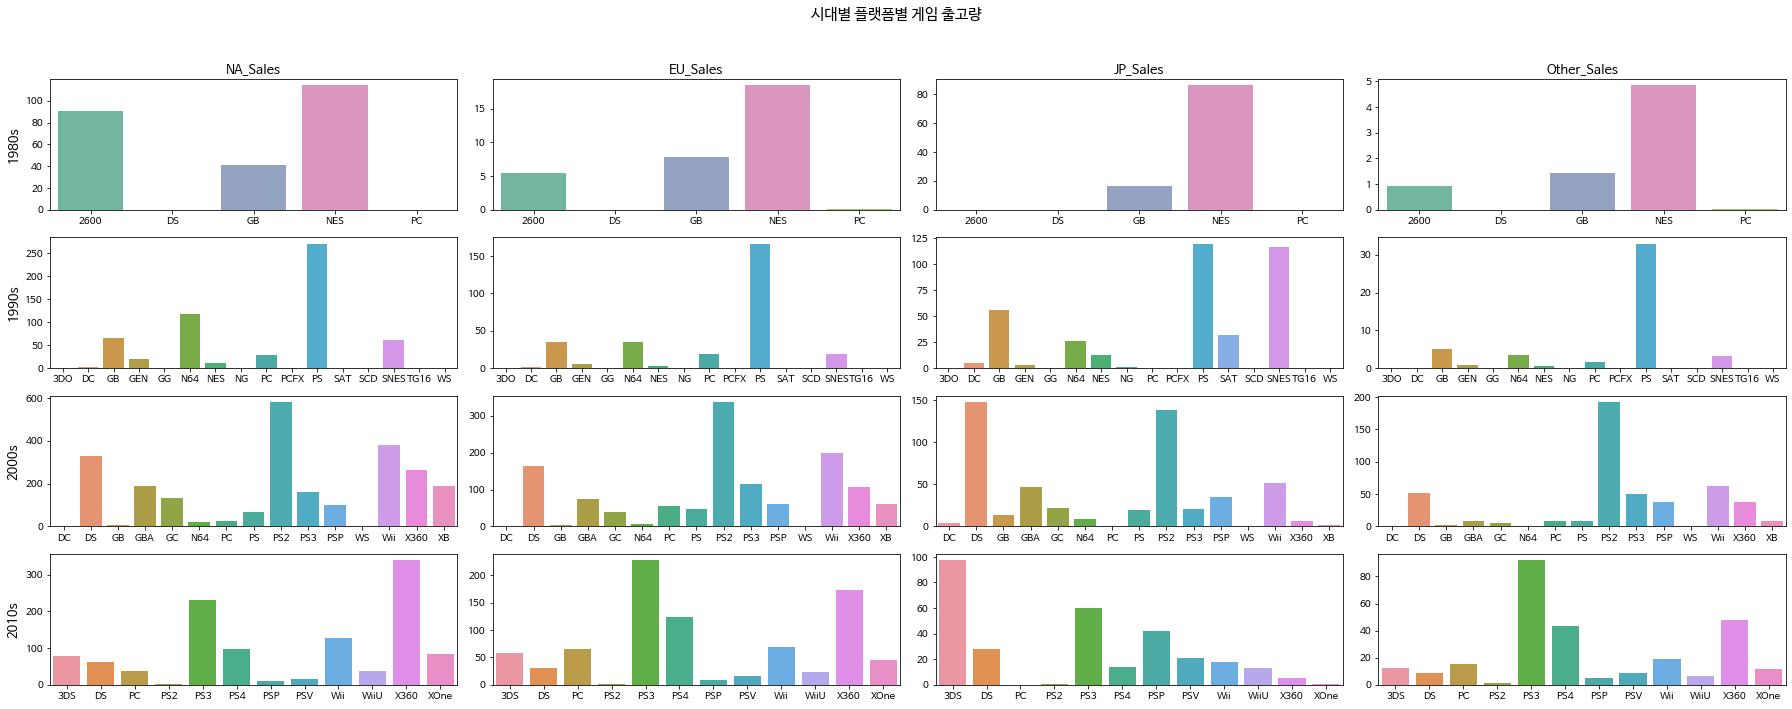

In [24]:
# 시대별 플랫폼별 장르별 출고량 

fig, ax = plt.subplots(4,4, figsize=(25,10))
fig.suptitle('시대별 플랫폼별 게임 출고량', fontsize = 15)  # overall titlte

for i, p in enumerate(periods):
    dy_period_plat = dy[dy.period == p].groupby(['Platform']).sum()
    for j, v in enumerate(region_cols):   
        sns.barplot(data = dy_period_plat, x = dy_period_plat.index, y = v,  ax = ax[i][j])   
        ax[i][j].set_ylabel('')  
        ax[i][j].set_xlabel('')  
   

ax[0][0].set_title('NA_Sales', fontsize = 13)
ax[0][1].set_title('EU_Sales',fontsize = 13)
ax[0][2].set_title('JP_Sales',fontsize = 13)
ax[0][3].set_title('Other_Sales',fontsize = 13)

ax[0][0].set_ylabel('1980s', fontsize = 13)
ax[1][0].set_ylabel('1990s',fontsize = 13)
ax[2][0].set_ylabel('2000s',fontsize = 13)
ax[3][0].set_ylabel('2010s',fontsize = 13)

fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.show()

### 결과해석
* 전체적으로 90년대부터 플랫폼 양상 변화
    - 80년대(NES/2600/GB) --> 90년대(PS) --> 2000년대(PS2-/DS/Wii) --> 2010년대(X360/PS~)
* 전체적인 플랫폼의 변화 양상은 지역별로 비슷하나 일본이 특이한 양상을 보임
* 미국
    - 전세계적 흐름과 유사하나 2010년대 X360의 인기가 타국가에 비해 압도적
* EU
    - 미국과 비슷한 양상을 보이나 2010년대 X360보다는 PS시리즈의 인기가 높음
* 일본
    - 90년대 : PS만큼 SNES 크게 인기  
    - 2000년대: PS만큼 DS 크게 인기
    - 2010년대: 3DS가 1위 

In [25]:
dy[dy.period == 1980].groupby(['Publisher']).sum().sort_values(by = 'NA_Sales', ascending = False).head(10).index

Index(['Nintendo', 'Atari', 'Activision', 'Capcom', 'Parker Bros.', 'Imagic',
       'Palcom', 'Coleco', 'Namco Bandai Games', 'Mattel Interactive'],
      dtype='object', name='Publisher')

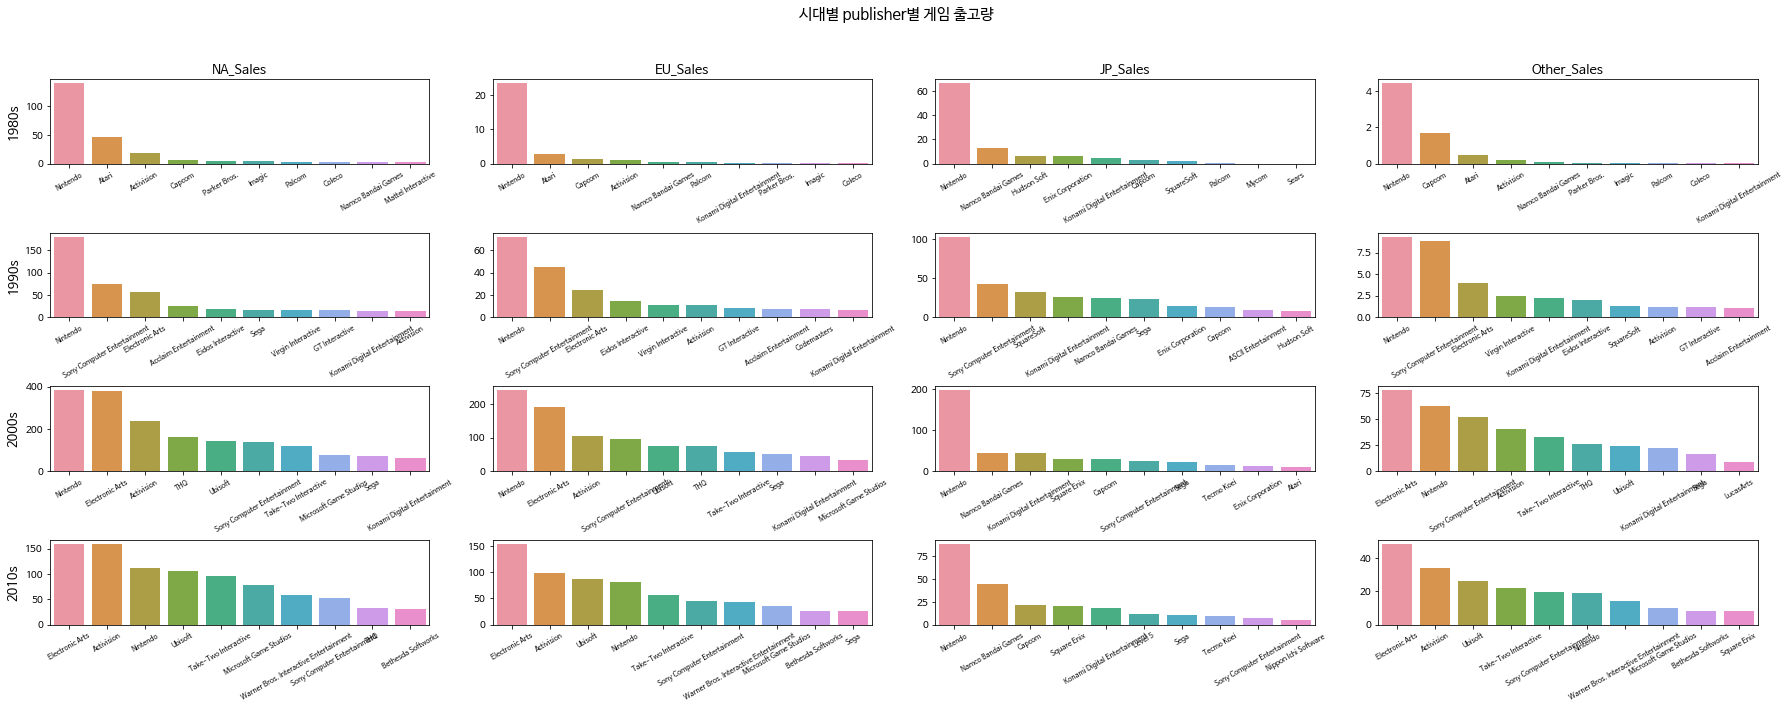

In [26]:
# 시대별 publisher별 출고량 

fig, ax = plt.subplots(4,4, figsize=(25,10))
fig.suptitle('시대별 publisher별 게임 출고량', fontsize = 15)  # overall titlte

for i, p in enumerate(periods):
    dy_period_pub = dy[dy.period == p].groupby(['Publisher']).sum()
    for j, v in enumerate(region_cols):   
        data = dy_period_pub.sort_values(by = v, ascending = False).head(10)
        g = sns.barplot(data = data, x = data.index, y = v,  ax = ax[i][j])   
        ax[i][j].set_ylabel('') 
        ax[i][j].set_xlabel('')   
        g.set_xticklabels(g.get_xticklabels(), rotation=30, fontsize='x-small')  ## 각 subplots xticklabel rotation(& fontsize) !!

ax[0][0].set_title('NA_Sales', fontsize = 13)
ax[0][1].set_title('EU_Sales',fontsize = 13)
ax[0][2].set_title('JP_Sales',fontsize = 13)
ax[0][3].set_title('Other_Sales',fontsize = 13)

ax[0][0].set_ylabel('1980s', fontsize = 13)
ax[1][0].set_ylabel('1990s',fontsize = 13)
ax[2][0].set_ylabel('2000s',fontsize = 13)
ax[3][0].set_ylabel('2010s',fontsize = 13)

fig.tight_layout()
fig.subplots_adjust(top=0.88)

plt.show()

### 결과해석
* 전세계적 흐름을 비슷하나 일본은 예외
* 2000년대까지는 NINTENDO가 압도적인 비중을 차지 -> 2000년: electronic arts 의 성장세가 눈에 띔(특히 미국/EU/기타 국가에서 높은 점유율) -> 2010년: activision의 점유율 향상, electronic arts 1위 등극
* 일본은 시대가 변해도 NINTENDO가 1위 

## 출고량이 높은 게임 

* 글로벌 - (총) 출고량 TOP 10 
    - 닌텐도: (wii)시리즈 / 슈퍼마리오, 테트리스(platform)/ 포켓몬(롤플레잉)/
    - 닌텐도 wii(2006)의 전세계 출고량 volume은 압도적 1위 

In [27]:
# 총 판매량 기준 출고량 top10 
dfk.sort_values(by = 'Global_Sales', ascending = False).head(10).style.bar(subset=['Global_Sales'], color = 'green')  

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.490000,29.020000,3.770000,8.460000,82.740000
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.080000,3.580000,6.810000,0.770000,40.240000
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.850000,12.880000,3.790000,3.310000,35.820000
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.750000,11.010000,3.280000,2.960000,33.000000
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.270000,8.890000,10.220000,1.000000,31.370000
5,6,Tetris,GB,1989,Puzzle,Nintendo,23.200000,2.260000,4.220000,0.580000,30.260000
6,7,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.380000,9.230000,6.500000,2.900000,30.010000
7,8,Wii Play,Wii,2006,Misc,Nintendo,14.030000,9.200000,2.930000,2.850000,29.020000
8,9,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.590000,7.060000,4.700000,2.260000,28.620000
9,10,Duck Hunt,NES,1984,Shooter,Nintendo,26.930000,0.630000,0.280000,0.470000,28.310000


* 미국 - (총) 출고량 TOP 10 
    - 글로벌 출고량과 비슷한 양상
    - 특이점은 x360게임이 TOP10에 포함

In [28]:
dfk.sort_values(by = 'NA_Sales', ascending = False).head(10).style.bar(subset=['Global_Sales'], color = 'green') 

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.490000,29.020000,3.770000,8.460000,82.740000
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.080000,3.580000,6.810000,0.770000,40.240000
9,10,Duck Hunt,NES,1984,Shooter,Nintendo,26.930000,0.630000,0.280000,0.470000,28.310000
5,6,Tetris,GB,1989,Puzzle,Nintendo,23.200000,2.260000,4.220000,0.580000,30.260000
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.850000,12.880000,3.790000,3.310000,35.820000
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.750000,11.010000,3.280000,2.960000,33.000000
15,16,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,14.970000,4.940000,0.240000,1.670000,21.820000
8,9,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.590000,7.060000,4.700000,2.260000,28.620000
7,8,Wii Play,Wii,2006,Misc,Nintendo,14.030000,9.200000,2.930000,2.850000,29.020000
18,19,Super Mario World,SNES,1990,Platform,Nintendo,12.780000,3.750000,3.540000,0.550000,20.610000


* 유럽 - (총) 출고량 TOP 10 
    - 글로벌 출고량과 비슷한 양상
    - 타 국가 대비 "Brain Age: Train Your Brain in Minutes a Day"의 출고량이 높은점이 특징

In [29]:
dfk.sort_values(by = 'EU_Sales', ascending = False).head(10).style.bar(subset=['Global_Sales'], color = 'green')

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.490000,29.020000,3.770000,8.460000,82.740000
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.850000,12.880000,3.790000,3.310000,35.820000
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.750000,11.010000,3.280000,2.960000,33.000000
10,11,Nintendogs,DS,2005,Simulation,Nintendo,9.070000,11.000000,1.930000,2.750000,24.760000
16,17,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.010000,9.270000,0.970000,4.140000,21.400000
19,20,Brain Age: Train Your Brain in Minutes a Day,DS,2005,Misc,Nintendo,4.750000,9.260000,4.160000,2.050000,20.220000
6,7,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.380000,9.230000,6.500000,2.900000,30.010000
7,8,Wii Play,Wii,2006,Misc,Nintendo,14.030000,9.200000,2.930000,2.850000,29.020000
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.270000,8.890000,10.220000,1.000000,31.370000
14,15,Wii Fit Plus,Wii,2009,Sports,Nintendo,9.090000,8.590000,2.530000,1.790000,22.000000


* 일본 - (총) 출고량 TOP 10 
    - 롤플레잉 장르가 TOP10에 다수 분포
    - wii 플랫폼이 상위랭크되지 않은 점이 특징

In [30]:
# 일본 (총) 출고량 TOP 10
dfk.sort_values(by = 'JP_Sales', ascending = False).head(10).style.bar(subset=['Global_Sales'], color = 'green')

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.270000,8.890000,10.220000,1.000000,31.370000
12,13,Pokemon Gold/Pokemon Silver,GB,1999,Role-Playing,Nintendo,9.000000,6.180000,7.200000,0.710000,23.100000
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,29.080000,3.580000,6.810000,0.770000,40.240000
6,7,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.380000,9.230000,6.500000,2.900000,30.010000
20,21,Pokemon Diamond/Pokemon Pearl,DS,2006,Role-Playing,Nintendo,6.420000,4.520000,6.040000,1.370000,18.360000
26,27,Pokemon Black/Pokemon White,DS,2010,Role-Playing,Nintendo,5.570000,3.280000,5.650000,0.820000,15.320000
25,26,Pokemon Ruby/Pokemon Sapphire,GBA,2002,Role-Playing,Nintendo,6.060000,3.900000,5.380000,0.500000,15.850000
41,42,Animal Crossing: Wild World,DS,2005,Simulation,Nintendo,2.550000,3.520000,5.330000,0.880000,12.270000
27,28,Brain Age 2: More Training in Minutes a Day,DS,2005,Puzzle,Nintendo,3.440000,5.360000,5.320000,1.180000,15.300000
214,215,Monster Hunter Freedom 3,PSP,2010,Role-Playing,Capcom,0.000000,0.000000,4.870000,0.000000,4.870000


* 기타 지역 - (총) 출고량 TOP 10 
    - 액션, 스포츠, 레이싱 장르가 상위권 랭크

In [31]:
dfk.sort_values(by = 'Other_Sales', ascending = False).head(10).style.bar(subset=['Global_Sales'], color = ['green'])

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
17,18,Grand Theft Auto: San Andreas,PS2,2004,Action,Take-Two Interactive,9.430000,0.400000,0.410000,10.570000,20.810000
0,1,Wii Sports,Wii,2006,Sports,Nintendo,41.490000,29.020000,3.770000,8.460000,82.740000
47,48,Gran Turismo 4,PS2,2004,Racing,Sony Computer Entertainment,3.010000,0.010000,1.100000,7.530000,11.660000
16,17,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.010000,9.270000,0.970000,4.140000,21.400000
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.850000,12.880000,3.790000,3.310000,35.820000
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.750000,11.010000,3.280000,2.960000,33.000000
348,349,Pro Evolution Soccer 2008,PS2,2007,Sports,Konami Digital Entertainment,0.050000,0.000000,0.640000,2.930000,3.630000
6,7,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.380000,9.230000,6.500000,2.900000,30.010000
7,8,Wii Play,Wii,2006,Misc,Nintendo,14.030000,9.200000,2.930000,2.850000,29.020000
10,11,Nintendogs,DS,2005,Simulation,Nintendo,9.070000,11.000000,1.930000,2.750000,24.760000


### 지역별 TOP 10 시각화
- 장르별/플랫폼별/publisher
- 방법 
    - plotly(pie chart)
    - seaborn(barplot)

In [32]:
## pie chart(plotly)
from plotly import express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

top_na = dfk.sort_values(by = ['NA_Sales'], ascending = False).head(10)
top_eu = dfk.sort_values(by = ['EU_Sales'], ascending = False).head(10)
top_jp = dfk.sort_values(by = ['JP_Sales'], ascending = False).head(10)
top_other = dfk.sort_values(by = ['Other_Sales'], ascending = False).head(10)

fig = px.sunburst(top_na, path = ['Genre', 'Publisher', 'Platform'], values = 'NA_Sales')
fig.update_layout(height=600, width=600, title_text="NA_Sales_TOP10")
fig.show()
print("")
fig = px.sunburst(top_eu, path = ['Genre', 'Publisher', 'Platform'], values = 'EU_Sales')
fig.update_layout(height=600, width=600, title_text="EU_Sales_TOP10")
fig.show()
print("")
fig = px.sunburst(top_jp, path = ['Genre', 'Publisher', 'Platform'], values = 'JP_Sales')
fig.update_layout(height=600, width=600, title_text="JP_Sales_TOP10")
fig.show()
print("")
fig = px.sunburst(top_other, path = ['Genre', 'Publisher', 'Platform'], values = 'Other_Sales')
fig.update_layout(height=600, width=600, title_text="Other_Sales_TOP10")
fig.show()


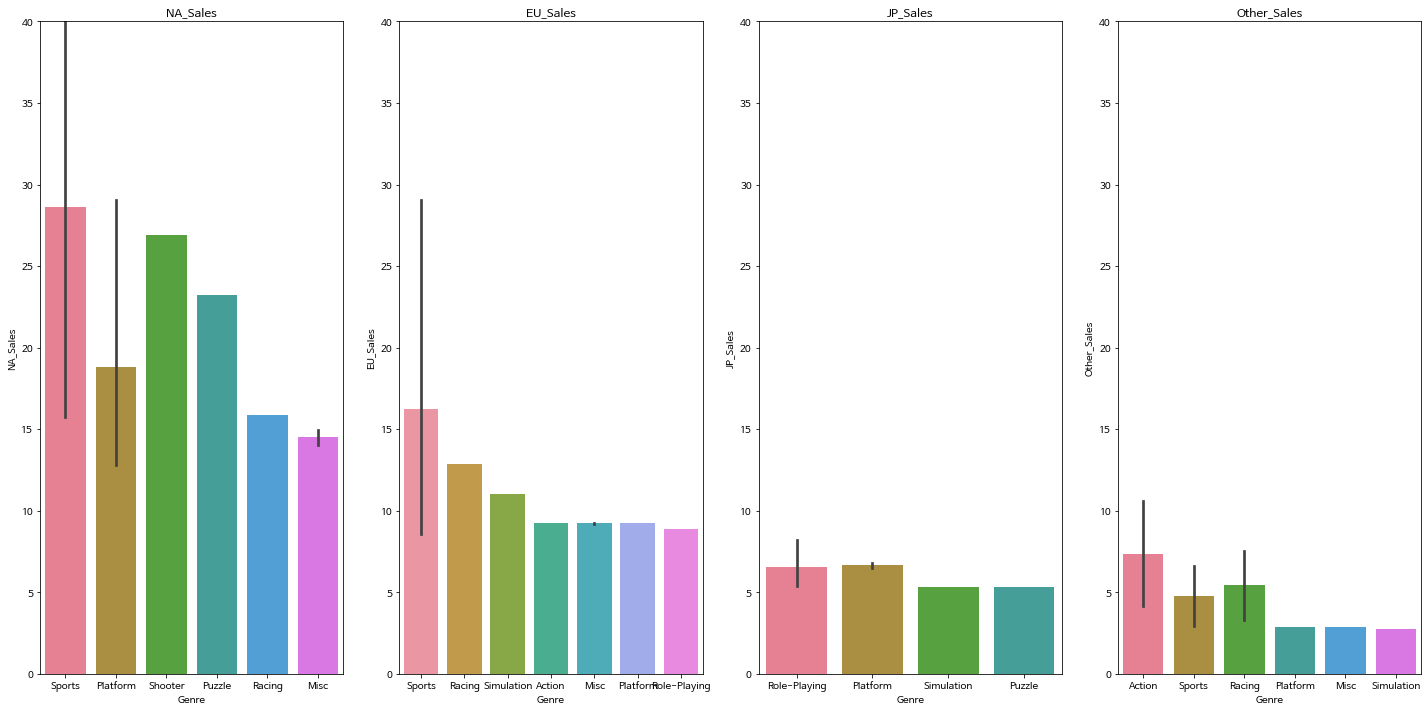

In [33]:
fig, axes = plt.subplots(1,4, figsize = (20,10))
ax = axes.flatten()
sns.set_palette("husl")

sns.barplot(y = 'NA_Sales', x = 'Genre',data= dfk.sort_values(by = 'NA_Sales', ascending = False).head(10),ax = ax[0])
sns.barplot(y = 'EU_Sales', x = 'Genre',data = dfk.sort_values(by = 'EU_Sales', ascending = False).head(10), ax = ax[1])
sns.barplot(y = 'JP_Sales', x = 'Genre',data = dfk.sort_values(by = 'JP_Sales', ascending = False).head(10), ax = ax[2])
sns.barplot(y = 'Other_Sales', x = 'Genre',data = dfk.sort_values(by = 'Other_Sales', ascending = False).head(10), ax = ax[3])

ax[0].set_ylim(0,40)
ax[1].set_ylim(0,40)
ax[2].set_ylim(0,40)
ax[3].set_ylim(0,40)


ax[0].set_title('NA_Sales')
ax[1].set_title('EU_Sales')
ax[2].set_title('JP_Sales')
ax[3].set_title('Other_Sales')

plt.tight_layout()



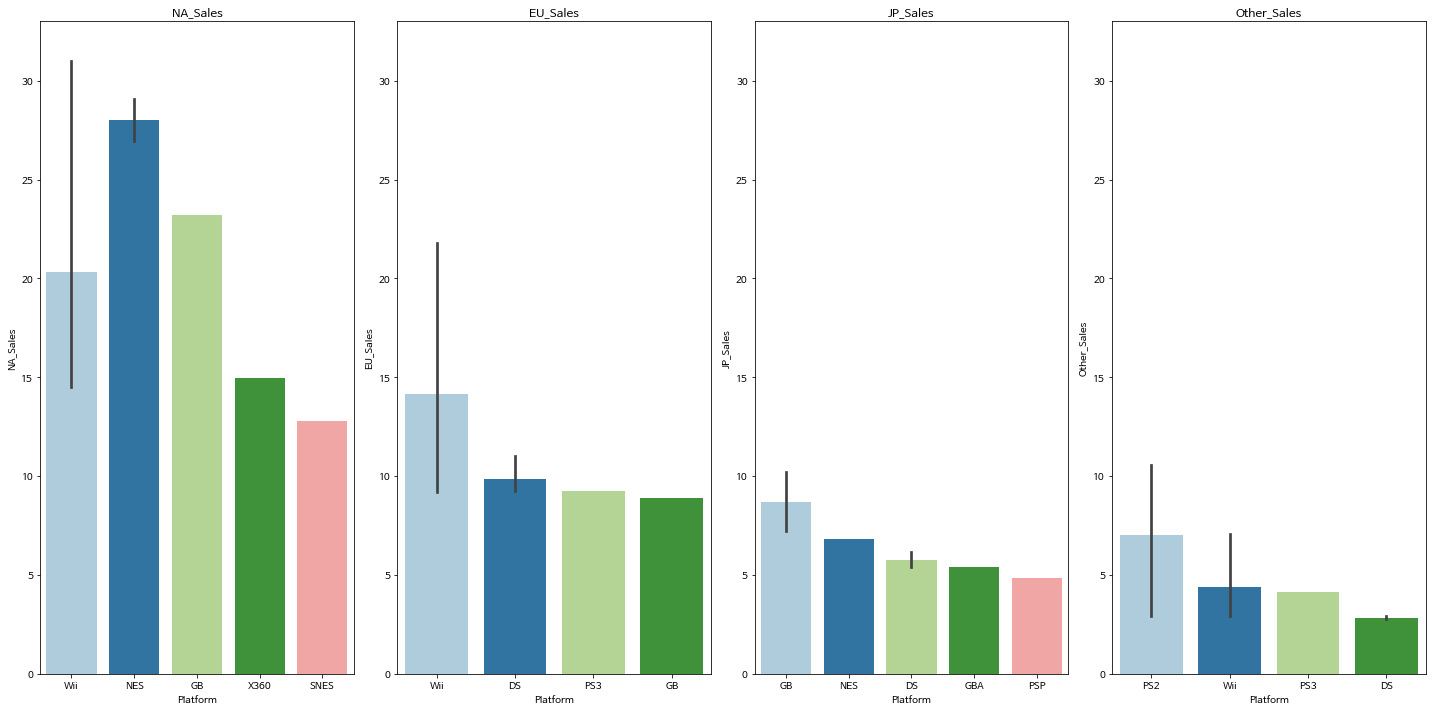

In [34]:
fig, axes = plt.subplots(1,4, figsize = (20,10))
ax = axes.flatten()
sns.set_palette("Paired")

sns.barplot(y = 'NA_Sales', x = 'Platform',data= dfk.sort_values(by = 'NA_Sales', ascending = False).head(10),ax = ax[0])
sns.barplot(y = 'EU_Sales', x = 'Platform',data = dfk.sort_values(by = 'EU_Sales', ascending = False).head(10), ax = ax[1])
sns.barplot(y = 'JP_Sales', x = 'Platform',data = dfk.sort_values(by = 'JP_Sales', ascending = False).head(10), ax = ax[2])
sns.barplot(y = 'Other_Sales', x = 'Platform',data = dfk.sort_values(by = 'Other_Sales', ascending = False).head(10), ax = ax[3])

ax[0].set_ylim(0,33)
ax[1].set_ylim(0,33)
ax[2].set_ylim(0,33)
ax[3].set_ylim(0,33)

ax[0].set_title('NA_Sales')
ax[1].set_title('EU_Sales')
ax[2].set_title('JP_Sales')
ax[3].set_title('Other_Sales')


plt.tight_layout()


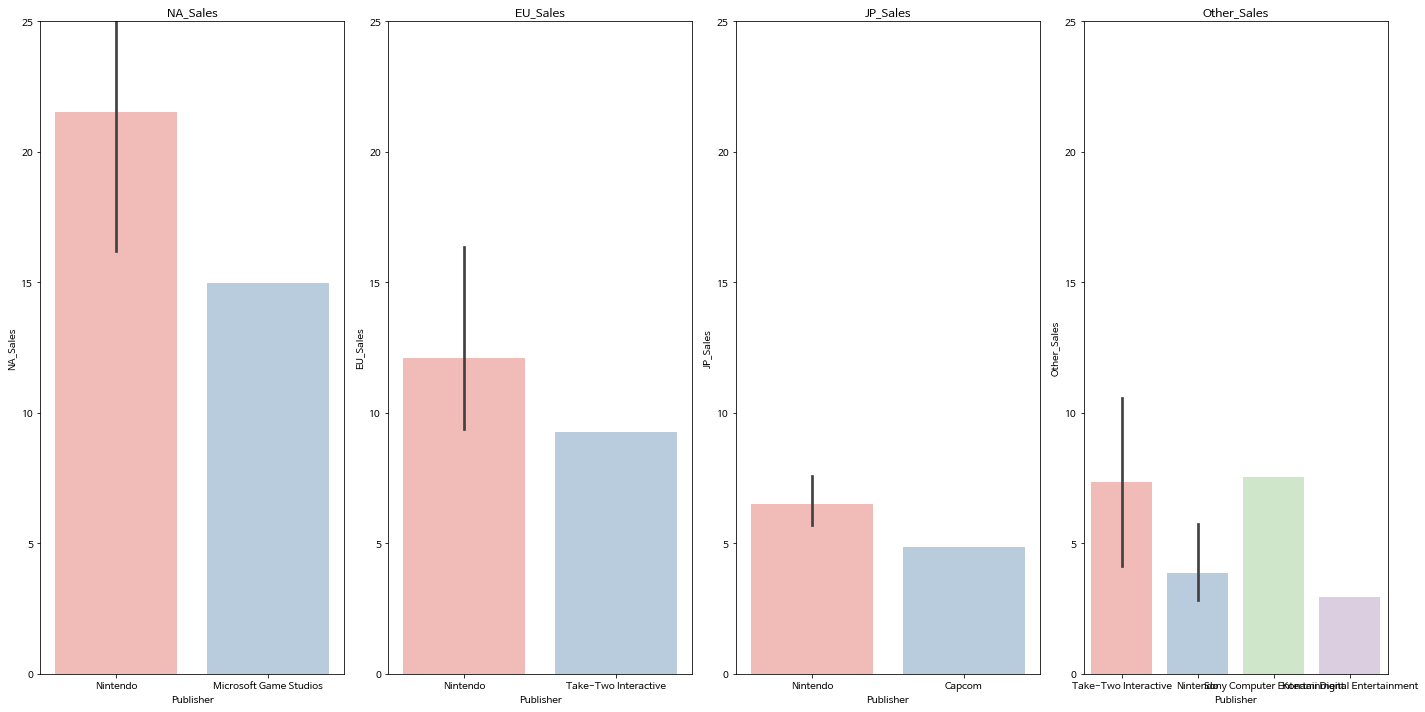

In [35]:
fig, axes = plt.subplots(1,4, figsize = (20,10))
ax = axes.flatten()
sns.set_palette("Pastel1")

sns.barplot(y = 'NA_Sales', x = 'Publisher',data= dfk.sort_values(by = 'NA_Sales', ascending = False).head(10),ax = ax[0])
sns.barplot(y = 'EU_Sales', x = 'Publisher',data = dfk.sort_values(by = 'EU_Sales', ascending = False).head(10), ax = ax[1])
sns.barplot(y = 'JP_Sales', x = 'Publisher',data = dfk.sort_values(by = 'JP_Sales', ascending = False).head(10), ax = ax[2])
sns.barplot(y = 'Other_Sales', x = 'Publisher',data = dfk.sort_values(by = 'Other_Sales', ascending = False).head(10), ax = ax[3])


ax[0].set_ylim(0,25)
ax[1].set_ylim(0,25)
ax[2].set_ylim(0,25)
ax[3].set_ylim(0,25)

ax[0].set_title('NA_Sales')
ax[1].set_title('EU_Sales')
ax[2].set_title('JP_Sales')
ax[3].set_title('Other_Sales')

plt.tight_layout()

### 장르별-지역별

#################   pd.melt   ####################

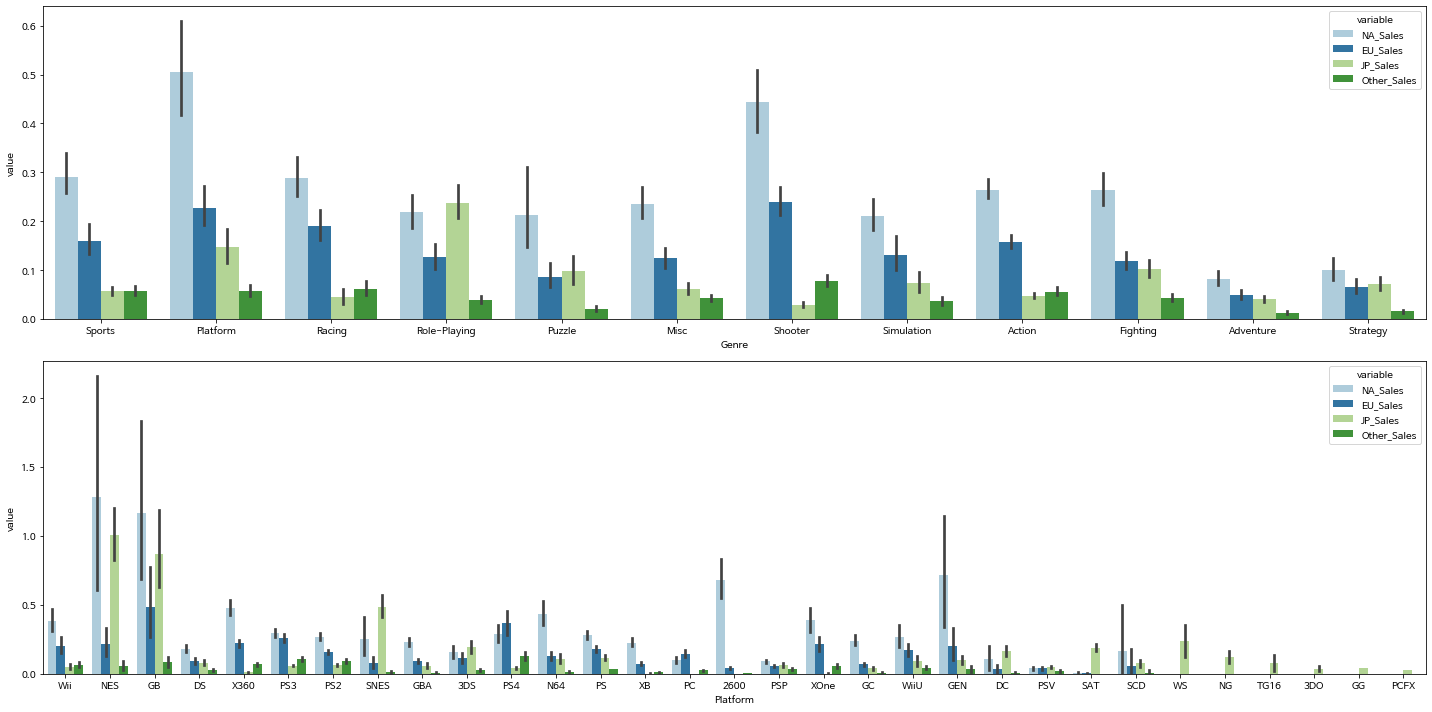

In [36]:
#dfk.groupby(['Genre']).sum()
gen_melt = pd.melt(dfk, id_vars = ['Genre'], value_vars = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales'])
plat_melt = pd.melt(dfk, id_vars = ['Platform'], value_vars = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales'])
pub_melt = pd.melt(dfk, id_vars = ['Publisher'], value_vars = ['NA_Sales','EU_Sales','JP_Sales','Other_Sales'])

fig, ax = plt.subplots(2,1,figsize = (20,10))
sns.set_palette('Paired')
sns.barplot(x = 'Genre', y = 'value', hue = 'variable', data =gen_melt, ax = ax[0])
sns.barplot(x = 'Platform', y = 'value', hue = 'variable', data =plat_melt, ax = ax[1])

plt.tight_layout()
plt.show();

## 가설검정

### 범주형 데이터 
- 교차분석(cross tabulation analysis) : 두 범주형 자료간의 상관관계 확인
```
교차표 만들기(관계) - 관측빈도, 기대빈도 확인 - 카이제곱 통계량 계산 - p-value 유의성 판단
```
-  카이제곱 검정 
    - 관찰된 빈도가 기대되는 빈도와 의미있게 다른지의 여부를 검정
```
chi^2 = Σ(관측값 - 기댓값)^2 / 기댓값
```

    - 독립성 검정: 두 가지 범주형 또는 명목형 변수가 관련될 가능성 여부 확인 
```
가정: 두 변수는 서로 연관이 없다(H0)
```
    - 주의) 기대빈도의 크기가 5이상이어야 함

In [37]:
from scipy.stats import chi2_contingency

#### genre - platform 독립성 검정
* [plot.bar(pandas)](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html)
- H0 기각 => 장르와 플랫폼(TOP10)은 연관성이 없다고 볼 수 없음 

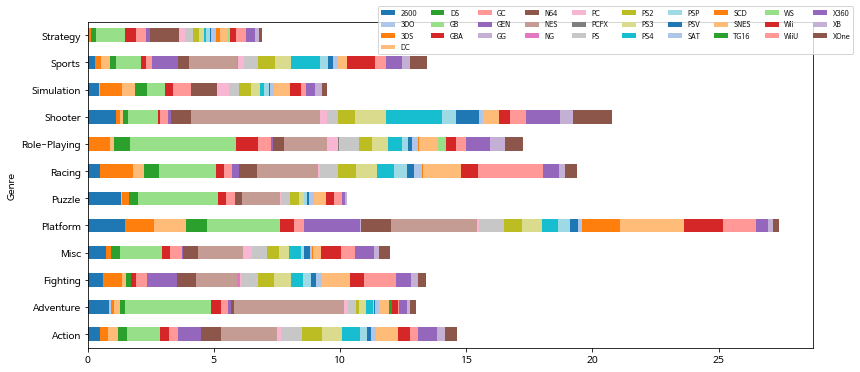

In [38]:
## genre-platform stacked 

sns.set_palette('tab20')
dfk.pivot_table(index = 'Genre', columns = 'Platform', values = 'Global_Sales').plot.barh(stacked = True, figsize = (13,6))
plt.legend(loc=(0.4,0.9), ncol= 10, fontsize = 'x-small')
plt.show()

In [39]:
pd.crosstab(dfk['Genre'], dfk['Platform'], margins = True)
## crosstab 의 data 값이 0이면 chi2 계산이 안됨. 적어도 5이상이어야 함 
# => 관측값이 5이상 되도록 변수 조정
pf_10 = dfk.Platform.value_counts().head(10).index
dfk_10 = dfk[dfk['Platform'].isin(pf_10)]

cross_10= pd.crosstab(dfk_10['Genre'], dfk_10['Platform'], margins = False) ## chi2 검증위해 margins = False
result = chi2_contingency(observed = cross_10, correction = False)
print("chi_squre:", result[0])
print("p-value:", result[1])

chi_squre: 3723.30807170939
p-value: 0.0


#### genre - publisher 독립성 검정
- H0 기각 => 장르와 publisher(TOP9)은 연관성이 없다고 볼 수 없음 

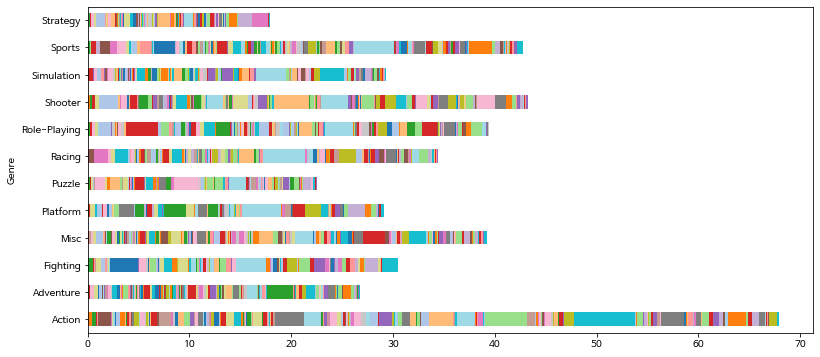

In [40]:
ax = dfk.pivot_table(index = 'Genre', columns = 'Publisher', values = 'Global_Sales').plot.barh(stacked = True, figsize = (13,6))
leg = plt.legend()
ax.get_legend().remove()  # 범례 삭제
plt.show()

In [41]:
pd.crosstab(dfk['Genre'], dfk['Publisher'], margins = False) 
pub_9 = dfk.Publisher.value_counts().head(9).index
dpub_9 = dfk[dfk['Publisher'].isin(pub_9)]

cross_9 = pd.crosstab(dpub_9['Genre'], dpub_9['Publisher'], margins = False) ## chi2 검증위해 margins = False
result = chi2_contingency(observed = cross_9, correction = False)
print("chi_squre:", result[0])
print("p-value:", result[1])

chi_squre: 2747.2686406464068
p-value: 0.0


### 수치형 데이터 
- 지역별 판매량 비교를 위해 데이터 표준화(StandardScaler 활용)
- 2010년대 데이터 기준으로 지역간 장르/플랫폼/publisher 따른 출고량 차이 존재하는지 ANOVA test

In [42]:
import scipy as sp

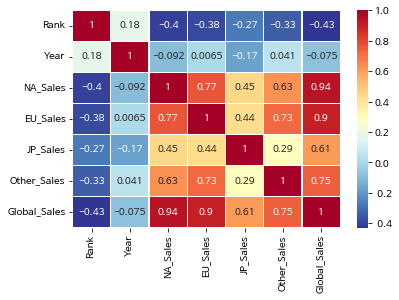

In [43]:
sns.heatmap(dfk.corr(), annot = True, linewidth=.2, cmap='RdYlBu_r');

In [44]:
from scipy import stats

In [45]:
### Sales 표준화 
from sklearn.preprocessing import StandardScaler
ds = dy.copy()
std = StandardScaler()
ds[['NA_Sales','EU_Sales',	'JP_Sales',	'Other_Sales', 'Global_Sales']] = std.fit_transform(ds[['NA_Sales','EU_Sales',	'JP_Sales',	'Other_Sales', 'Global_Sales']])
ds

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,period
0,1,Wii Sports,Wii,2006,Sports,Nintendo,50.480508,57.136930,11.938058,44.606085,52.864025,2000
1,2,Super Mario Bros.,NES,1985,Platform,Nintendo,35.284437,6.794188,21.767296,3.828224,25.532503,1980
2,3,Mario Kart Wii,Wii,2008,Racing,Nintendo,19.084273,25.197785,12.002724,17.297115,22.690025,2000
3,4,Wii Sports Resort,Wii,2009,Sports,Nintendo,18.961823,21.497277,10.353740,15.441165,20.876498,2000
4,5,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,13.476053,17.302048,32.792857,5.047848,19.828254,1990
...,...,...,...,...,...,...,...,...,...,...,...,...
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002,Platform,Kemco,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,2000
16594,16597,Men in Black II: Alien Escape,GC,2003,Shooter,Infogrames,-0.311841,-0.290207,-0.251492,-0.254864,-0.339194,2000
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008,Racing,Activision,-0.324086,-0.290207,-0.251492,-0.254864,-0.339194,2000
16596,16599,Know How 2,DS,2010,Puzzle,7G//AMES,-0.324086,-0.270418,-0.251492,-0.254864,-0.339194,2010


In [46]:
ds_10 = ds.query('period == 2010')  # 2010년대 기준 데이터로 범위를 좁혀서 가설 검정

In [47]:
def h_test(df, column, value):
    d = df[df[column] == value]
    print("북미/EU 비교:", stats.ttest_ind(d.NA_Sales, d.EU_Sales))
    print("북미/일본 비교:", stats.ttest_ind(d.NA_Sales, d.JP_Sales))
    print("글로벌/일본 비교:", stats.ttest_ind(d.Global_Sales, d.JP_Sales))
    print("북미/EU/일본 비교:", stats.f_oneway(d.NA_Sales, d.EU_Sales, d.JP_Sales))
    print("글로벌/북미/EU 비교:", stats.f_oneway(d.Global_Sales, d.NA_Sales, d.EU_Sales))
    print("글로벌/북미/일본 비교:", stats.f_oneway(d.Global_Sales, d.NA_Sales, d.JP_Sales))
    print("글로벌/북미/EU/일본 비교:", stats.f_oneway(d.Global_Sales, d.NA_Sales, d.EU_Sales, d.JP_Sales))
    print("4개국 비교:", stats.f_oneway(d.NA_Sales, d.EU_Sales, d.JP_Sales, d.Other_Sales))
    return None

In [48]:
for value in ['Nintendo', 'Activision', 'Electronic Arts']:
    print(f"publisher: {value}")
    h_test(ds_10, 'Publisher', value)
    print("="*50)

publisher: Nintendo
북미/EU 비교: Ttest_indResult(statistic=-1.0480228432682206, pvalue=0.2953769023801123)
북미/일본 비교: Ttest_indResult(statistic=-3.9831608563529706, pvalue=8.331077699379625e-05)
글로벌/일본 비교: Ttest_indResult(statistic=-2.5221595236001653, pvalue=0.01212248072497208)
북미/EU/일본 비교: F_onewayResult(statistic=10.833474421595811, pvalue=2.4708143444205395e-05)
글로벌/북미/EU 비교: F_onewayResult(statistic=1.6575636920981247, pvalue=0.19163398904787013)
글로벌/북미/일본 비교: F_onewayResult(statistic=9.391913874060391, pvalue=9.882946879556663e-05)
글로벌/북미/EU/일본 비교: F_onewayResult(statistic=7.721063861256284, pvalue=4.462223828723915e-05)
4개국 비교: F_onewayResult(statistic=12.508496741928171, pvalue=5.735081146506596e-08)
publisher: Activision
북미/EU 비교: Ttest_indResult(statistic=-0.34212674305439644, pvalue=0.7323615366741365)
북미/일본 비교: Ttest_indResult(statistic=5.804841634470076, pvalue=9.89664241447904e-09)
글로벌/일본 비교: Ttest_indResult(statistic=5.378298701659586, pvalue=1.0361480955182931e-07)
북미/EU/일

#### 결과해석
- 2010년대 기준
    - publisher : NINTENDO - 북미와 EU의 출고량 유사
    - publisher : Activision - 글로벌/북미/EU 출고량 유사
    - publisher : Electronic Arts - 지역간 유의한 차이 있다고 볼 수 있음 

In [49]:
for value in ['Wii', 'X360']:
    print(f"platform: {value}")
    h_test(ds_10, 'Platform', value)
    print("="*50)

platform: Wii
북미/EU 비교: Ttest_indResult(statistic=0.12150930811272583, pvalue=0.9033147058652353)
북미/일본 비교: Ttest_indResult(statistic=3.2728939099583703, pvalue=0.0011049826110978665)
글로벌/일본 비교: Ttest_indResult(statistic=2.5163190350101305, pvalue=0.012031331737964975)
북미/EU/일본 비교: F_onewayResult(statistic=6.019820304440618, pvalue=0.002495678802881832)
글로벌/북미/EU 비교: F_onewayResult(statistic=0.2581108793296425, pvalue=0.7725476013671176)
글로벌/북미/일본 비교: F_onewayResult(statistic=5.420803919616963, pvalue=0.004520192224374962)
글로벌/북미/EU/일본 비교: F_onewayResult(statistic=3.9822262927624235, pvalue=0.007695791752433195)
4개국 비교: F_onewayResult(statistic=4.472192964583309, pvalue=0.0038999385211986024)
platform: X360
북미/EU 비교: Ttest_indResult(statistic=1.018461718165336, pvalue=0.30863182785563226)
북미/일본 비교: Ttest_indResult(statistic=9.287190156284133, pvalue=5.735343217466016e-20)
글로벌/일본 비교: Ttest_indResult(statistic=9.10178641587181, pvalue=2.920257658060099e-19)
북미/EU/일본 비교: F_onewayResult(st

#### 결과해석
- 2010년대 기준
    - platform : Wii, X360 - 글로벌/북미와 EU의 출고량 유사  

In [50]:
for value in ['Sports', 'Action','Shooter', 'Role-Playing']:
    print(f"Genre: {value}")
    h_test(ds_10, 'Genre', value)
    print("="*50)

Genre: Sports
북미/EU 비교: Ttest_indResult(statistic=-1.9303209674522543, pvalue=0.05381145604970913)
북미/일본 비교: Ttest_indResult(statistic=6.429217281046868, pvalue=1.8723923668352138e-10)
글로벌/일본 비교: Ttest_indResult(statistic=6.421668992837753, pvalue=1.964286076355763e-10)
북미/EU/일본 비교: F_onewayResult(statistic=19.823119750623956, pvalue=3.0751948120836437e-09)
글로벌/북미/EU 비교: F_onewayResult(statistic=2.640178241074722, pvalue=0.07163536062125508)
글로벌/북미/일본 비교: F_onewayResult(statistic=21.91908372943716, pvalue=3.971953514633623e-10)
글로벌/북미/EU/일본 비교: F_onewayResult(statistic=14.404191098252952, pvalue=2.6835028365826335e-09)
4개국 비교: F_onewayResult(statistic=15.874564440174925, pvalue=3.229384994823946e-10)
Genre: Action
북미/EU 비교: Ttest_indResult(statistic=-3.995813526625384, pvalue=6.60727115498009e-05)
북미/일본 비교: Ttest_indResult(statistic=0.6960149293121186, pvalue=0.48647510187549037)
글로벌/일본 비교: Ttest_indResult(statistic=2.1858286280539447, pvalue=0.02890763733291131)
북미/EU/일본 비교: F_onewayR

#### 결과해석
- 2010년대 기준
    - genre : Action - 북미와 일본의 출고량 유사
    - genre :Shooter, Role-playing - 글로벌/북미/EU 출고량 유사

#### 장르/플랫폼 따른 글로벌 매출 비교 시각화 

* 장르에 따른 글로벌 매출 비교


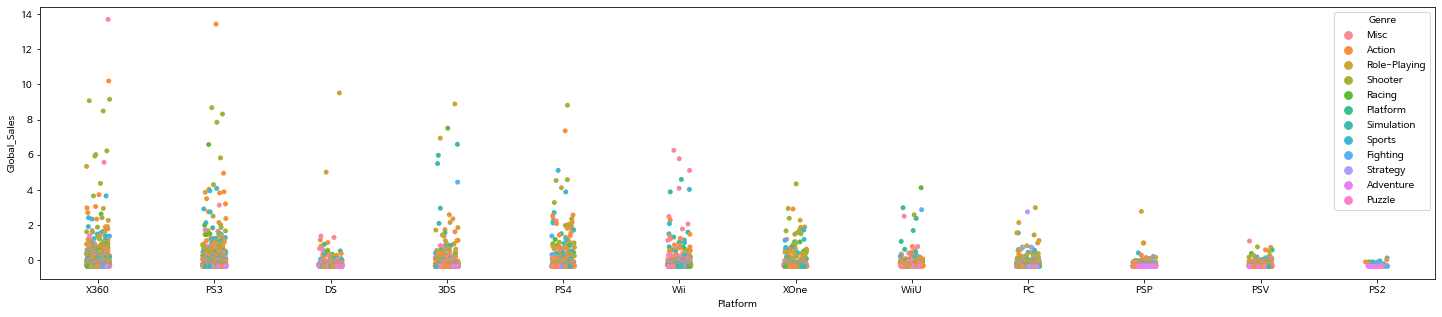

In [51]:
plt.figure(figsize=(25,5))
sns.set_palette('husl')
sns.stripplot(data = ds_10, x = 'Platform', y = 'Global_Sales', hue = 'Genre')
plt.show();

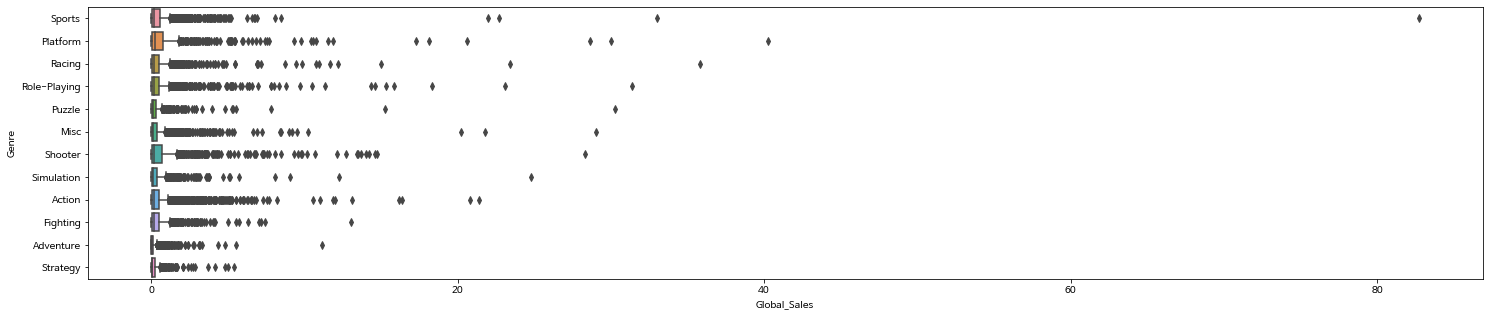

In [52]:
plt.figure(figsize=(25,5))
sns.boxplot(data = dy, y = 'Genre', x = 'Global_Sales')

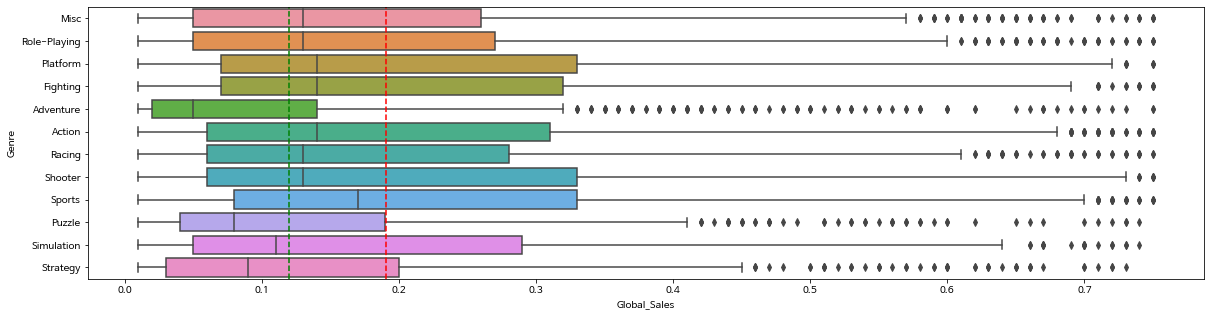

In [53]:
dy.Global_Sales.describe()  # 0.47(75%)
dy_cut = dy.query('Global_Sales <= 0.75')

plt.figure(figsize=(20,5))
sns.boxplot(data = dy_cut, y = 'Genre', x = 'Global_Sales')
plt.axvline(dy_cut.Global_Sales.mean(), color = 'r', linestyle = '--')   # 평균
plt.axvline(dy_cut.Global_Sales.median(), color = 'g', linestyle = '--')  # 중앙값
plt.show();

* 플랫폼 따른 매출 

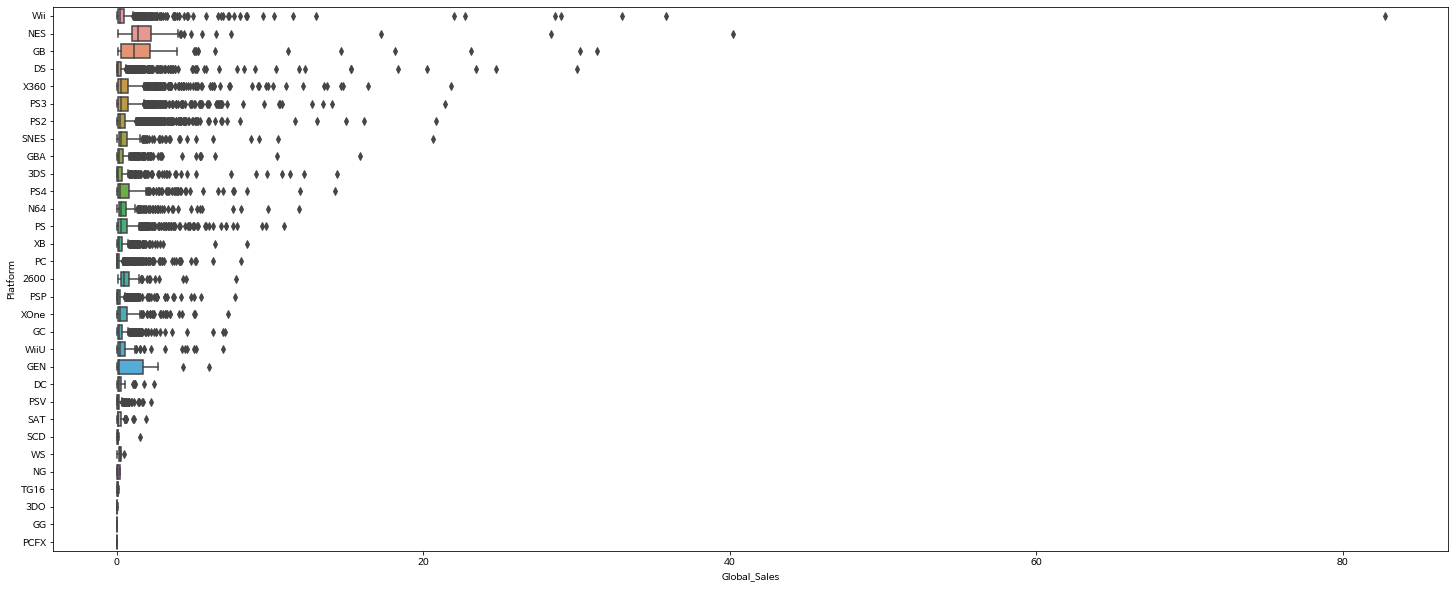

In [54]:
plt.figure(figsize=(25,10))
sns.boxplot(data = dy, y = 'Platform', x = 'Global_Sales')
plt.show();

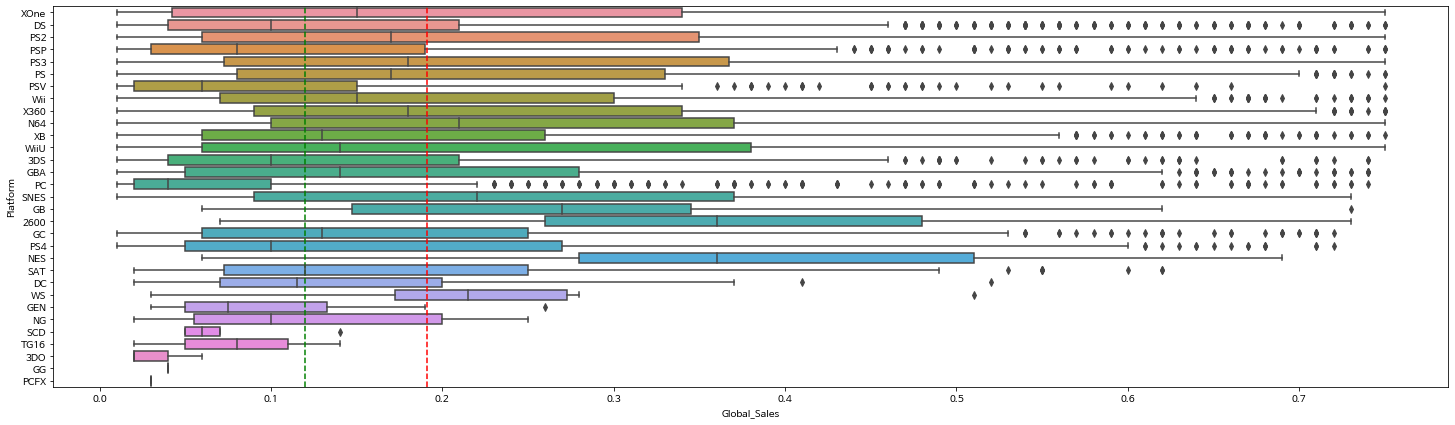

In [55]:
plt.figure(figsize=(25,7))
sns.boxplot(data = dy_cut, y = 'Platform', x = 'Global_Sales')
plt.axvline(dy_cut.Global_Sales.mean(), color = 'r', linestyle = '--')   # 평균
plt.axvline(dy_cut.Global_Sales.median(), color = 'g', linestyle = '--')  # 중앙값
plt.show();